# Dataset: Split train and validation

In [11]:
import glob
import os

import random
from collections import defaultdict

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import transforms

import timm
import torchvision.models as models

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

In [2]:
class TrainDatasetForThreeModel(Dataset):
    class MaskLabels:
        mask = 0
        incorrect = 1
        normal = 2
        
    class GenderLabels:
        male = 0
        female = 1
        
    class AgeGroup:
        map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2
        
        
    _file_names = {
        "mask1": MaskLabels.mask,
        "mask2": MaskLabels.mask,
        "mask3": MaskLabels.mask,
        "mask4": MaskLabels.mask,
        "mask5": MaskLabels.mask,
        "incorrect_mask": MaskLabels.incorrect,
        "normal": MaskLabels.normal
    }
    
    def __init__(self, data_dir, category='all', transform=None, val_ratio=0.2):
        self.data_dir = data_dir  # '/opt/ml/input/data/train/images'
        self.img_paths = list()
        self.indices = defaultdict(list)
        
        self.val_ratio = val_ratio
        self.transform = transform
        self.setup()
        
        if category not in ['all', 'age', 'gender', 'mask']:
            raise ValueError("category can have only 'all', 'age', 'gender' or 'mask'")
        self.category = category
    
    @staticmethod
    def split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)
        
        val_indices = set(random.choices(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }
        
    def setup(self):
        profiles = glob.glob(os.path.join(self.data_dir, '*'))
        # /opt/ml/input/data/train/images/Asia_30, 
        # /opt/ml/input/data/train/images/Asia_54, ...
        split_profiles = self.split_profile(profiles, self.val_ratio)
        
        cnt = 0
        for phase, indices in split_profiles.items():
            for idx in indices:
                img_dir = profiles[idx]
                seven_img_paths = glob.glob(os.path.join(img_dir, '*'))
                
                length = len(seven_img_paths)  # 7
                self.img_paths.extend(seven_img_paths)
                self.indices[phase].extend(range(cnt, cnt+length))
                cnt += length
                
    def set_transform(self, transform):
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        label = self.get_label(img_path)
    
        img_transform = self.transform(img)
        return img_transform, label
        
    def get_label(self, img_path):
        folder_name, file_name = img_path.split('/')[-2:]
        _, gender, _, age = folder_name.split('_')
        
        if self.category == 'all':
            age_label = self.AgeGroup.map_label(age)
            gender_label = getattr(self.GenderLabels, gender)
            mask_label = self._file_names[file_name]
            label = age_label + gender_label*3 + mask_label*6
            
        elif self.category == 'age':
            label = self.AgeGroup.map_label(age)
                
        elif self.category == 'gender':
            label = getattr(self.GenderLabels, gender)
            
        elif self.category == 'mask':
            file_name = file_name.split('.')[0]
            label = self._file_names[file_name]
            
        return label
    
    def __len__(self):
        return len(self.img_paths)
    
    def split_dataset(self):
        return [Subset(self, indices) for phase, indices in self.indices.items()]

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
batch_size = 16

In [7]:
# Dataset and Data Loader
data_dir = '/opt/ml/input/data/train/images'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
])

age_dataset = TrainDatasetForThreeModel(data_dir, category='age', transform=transform)
age_train_dataset, age_val_dataset = age_dataset.split_dataset()

age_train_loader = DataLoader(
    age_train_dataset, 
    batch_size=batch_size,
    drop_last=True,
    pin_memory=use_cuda,
    shuffle=True, 
    num_workers=4
)

age_val_loader = DataLoader(
    age_val_dataset,
    batch_size=batch_size, 
    drop_last=True, 
    pin_memory=use_cuda,
    shuffle=False, 
    num_workers=4
)

Text(0.5, 1.0, '0')

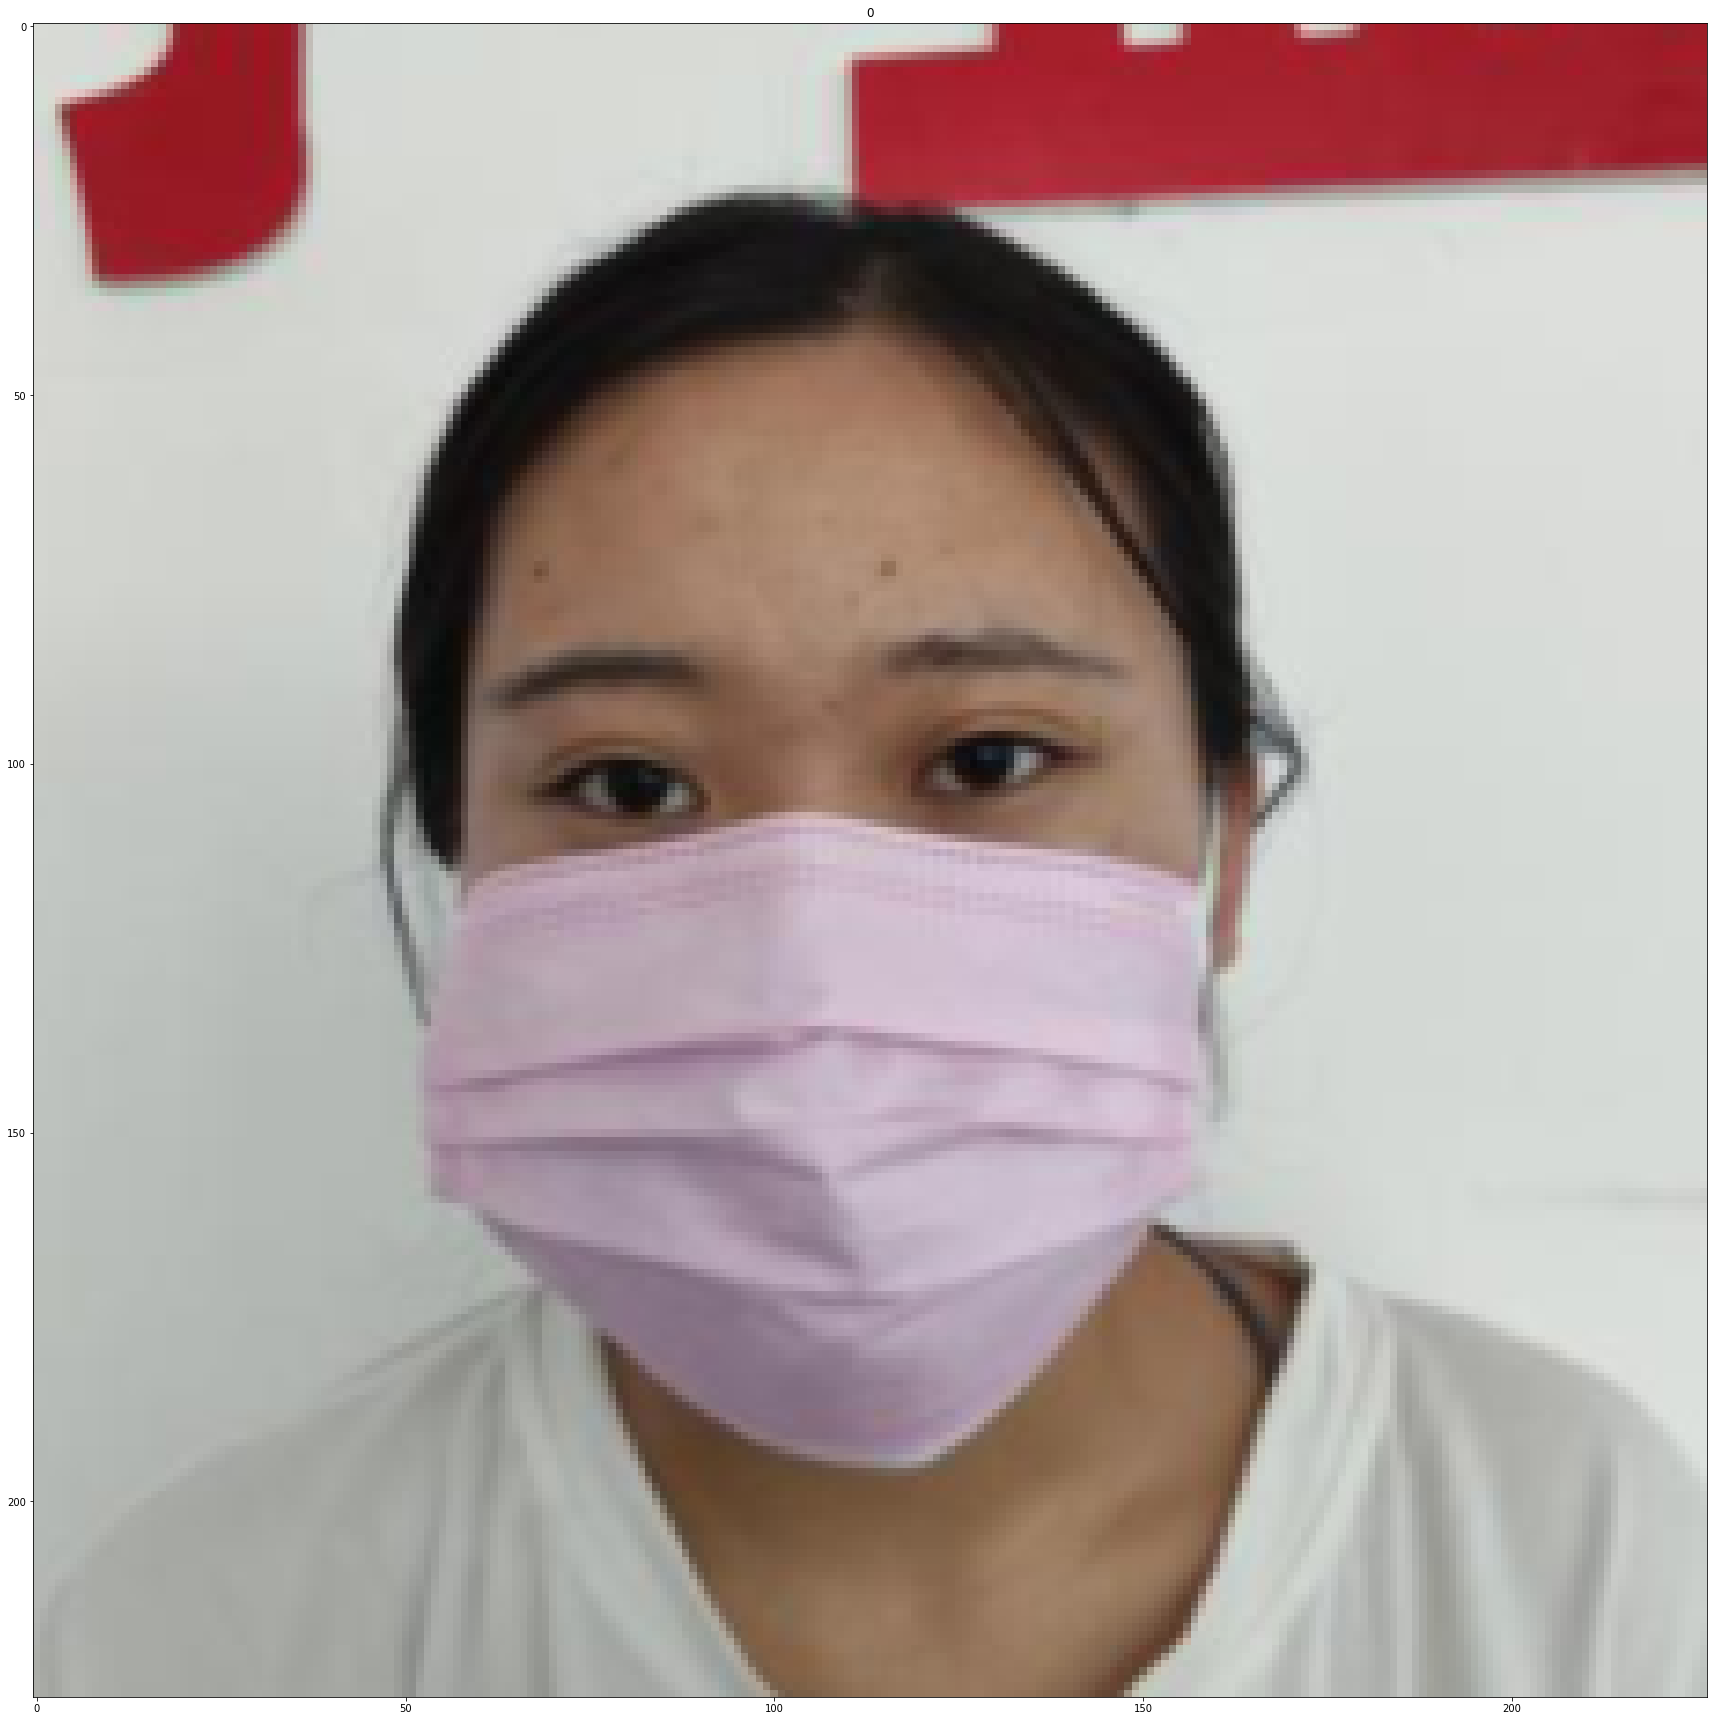

In [24]:
fig = plt.figure(figsize=(30, 50))

img, label = next(iter(age_train_dataset))
img = img.permute(1, 2, 0)

ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

title = str(label)
ax.set_title(title)

In [20]:
# Dataset and Data Loader
gender_dataset = TrainDatasetForThreeModel(data_dir, category='gender', transform=transform)
gender_train_dataset, gender_val_dataset = gender_dataset.split_dataset()

gender_train_loader = DataLoader(
    gender_train_dataset, 
    batch_size=batch_size,
    drop_last=True,
    pin_memory=use_cuda,
    shuffle=True, 
    num_workers=4
)

gender_val_loader = DataLoader(
    gender_val_dataset,
    batch_size=batch_size, 
    drop_last=True, 
    pin_memory=use_cuda,
    shuffle=False, 
    num_workers=4
)

In [ ]:
# Dataset and Data Loader
mask_dataset = TrainDatasetForThreeModel(data_dir, category='mask', transform=transform)
mask_train_dataset, mask_val_dataset = mask_dataset.split_dataset()

mask_train_loader = DataLoader(
    mask_train_dataset, 
    batch_size=batch_size,
    drop_last=True,
    pin_memory=use_cuda,
    shuffle=True, 
    num_workers=4
)

mask_val_loader = DataLoader(
    mask_val_dataset,
    batch_size=batch_size, 
    drop_last=True,
    pin_memory=use_cuda,
    shuffle=False, 
    num_workers=4
)

# Model: GoogleNet

In [ ]:
age_model = models.googlenet(pretrained=True)
age_model.fc

In [ ]:
num_class = 3

age_model.fc = nn.Sequential(    
    nn.Linear(1024, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_class),
)

In [ ]:
gender_model = models.googlenet(pretrained=True)
num_class = 2

gender_model.fc = nn.Sequential(    
    nn.Linear(1024, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_class),
)
gender_model.fc

In [ ]:
mask_model = models.googlenet(pretrained=True)
num_class = 3

mask_model.fc = nn.Sequential(    
    nn.Linear(1024, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_class),
)
mask_model.fc

# Train

In [ ]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
#    torch.backends.cudnn.deterministic = True
#    torch.backends.cudnn.benchmark = False # https://discuss.pytorch.org/t/unable-to-find-a-valid-cudnn-algorithm-to-run-convolution/78724
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
seed_everything(42)
log_interval = 100
epochs = 1

###### Category model (Age) ######
model = age_model
model.to(device)
train_loader = age_train_loader
val_loader = age_val_loader
val_set = age_val_dataset
weight = [1, 1, 6]
###################################

weight = torch.FloatTensor(weight).to(device)

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

best_val_acc = 0
best_val_loss = np.inf

In [ ]:
###### Category model (Age) ######
for epoch in range(epochs):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(tqdm(train_loader)):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)lo
        
        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if idx % log_interval == 0:
            train_loss = loss_value / log_interval
            train_acc = matches / batch_size / log_interval
            current_lr = get_lr(optimizer)
            print(
                f"Epoch[{epoch}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )

            loss_value = 0
            matches = 0
            
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        best_val_loss = min(best_val_loss, val_loss)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
        print()

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
seed_everything(42)
log_interval = 100
epochs = 1

###### Category model (Gender) ######
model = gender_model
model.to(device)
train_loader = gender_train_loader
val_loader = gender_val_loader
val_set = gender_val_dataset
weights = [0.3, 0.2]
weights = torch.FloatTensor(weights).to(device)
###################################

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

best_val_acc = 0
best_val_loss = np.inf

In [ ]:
###### Category model (Gender) ######
for epoch in range(epochs):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(tqdm(train_loader)):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if idx % log_interval == 0:
            train_loss = loss_value / log_interval
            train_acc = matches / batch_size / log_interval
            current_lr = get_lr(optimizer)
            print(
                f"Epoch[{epoch}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )

            loss_value = 0
            matches = 0
            
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        best_val_loss = min(best_val_loss, val_loss)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
        print()

In [ ]:
seed_everything(42)
log_interval = 100
epochs = 1

###### Category model (Mask) ######
model = mask_model
model.to(device)
train_loader = mask_train_loader
val_loader = mask_val_loader
val_set = mask_val_dataset
weight = [1, 5, 5]
###################################

weight = torch.tensor(weight).float().cuda()

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

best_val_acc = 0
best_val_loss = np.inf

In [ ]:
###### Category model (Mask) ######
for epoch in range(epochs):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(tqdm(train_loader)):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if idx % log_interval == 0:
            train_loss = loss_value / log_interval
            train_acc = matches / batch_size / log_interval
            current_lr = get_lr(optimizer)
            print(
                f"Epoch[{epoch}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )

            loss_value = 0
            matches = 0
            
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        best_val_loss = min(best_val_loss, val_loss)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
        print()

# Test

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_dir = '/opt/ml/input/data/eval'

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

len(dataset)

In [ ]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

age_model.eval()
gender_model.eval()
mask_model.eval()

all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        
        age_pred = age_model(images)
        age_pred = age_pred.argmax(dim=-1)
        
        gender_pred = gender_model(images)
        gender_pred = gender_pred.argmax(dim=-1) * 3
        
        mask_pred = mask_model(images)
        mask_pred = mask_pred.argmax(dim=-1) * 6
        
        pred = age_pred + gender_pred + mask_pred
        
        all_predictions.extend(pred.cpu().numpy())
        
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join('.', 'submission_v2.csv'), index=False)
print('test inference is done!')

In [ ]:
exist_class = np.array(submission['ans'].value_counts().index)
not_exist_class = {}
for i in range(18):
    if i not in exist_class:
        not_exist_class[i] = 0
        
not_exist_class = pd.Series(not_exist_class)
answer = submission['ans'].value_counts()

answer = pd.concat([answer, not_exist_class])
answer = answer.sort_index()
answer

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Transform: ToTensor()
**Accuracy: 19.7143% F1-score: 0.1336**

In [ ]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(x=np.arange(18), y=answer, palette=['#FEA443', '#F3FEB0', '#F2EDD0'])

plt.xticks(np.arange(18), np.arange(18))
plt.title('Answer Ratio', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Images', fontsize=12)

counts_pct = [f'{elem * 100:.2f}%' for elem in answer / answer.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment='center', size=12, color='black', fontweight='bold')
    
plt.show()

### Transform: ToTensor(), CenterCrop()
**Accuracy: 12.0794% F1-Score: 0.0241**

In [ ]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(x=np.arange(18), y=answer, palette=['#FEA443', '#F3FEB0', '#F2EDD0'])

plt.xticks(np.arange(18), np.arange(18))
plt.title('Answer Ratio', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Images', fontsize=12)

counts_pct = [f'{elem * 100:.2f}%' for elem in answer / answer.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment='center', size=12, color='black', fontweight='bold')
    
plt.show()